In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (515/515), done.
remote: Compressing objects: 100% (278/278), done.
remote: Total 515 (delta 245), reused 479 (delta 231), pack-reused 0
Receiving objects: 100% (515/515), 29.39 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (245/245), done.
/kaggle/working/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
#hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


# Multilingual Named Entity Recognition

## The Dataset

In [3]:
#id jeff-dean-ner
#caption An example of a sequence annotated with named entities
#hide_input
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


* To load one of the `PAN-X` subsets in `XTREME`, we'll nee to know which data configuration to pass the `load_dataset()` function. Let's use the `get_dataset_config_names()` function to find out which subsets are available:

In [4]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

Downloading:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

XTREME has 183 configurations


* A lot of configuration! Let's narrow our search:

In [5]:
# finda configurations starts with PAN
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [6]:
# load the German corpus
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

* Lets create a realistic Swiss corpus. That is, we'll sample German, French, Italian, and English corpora from `PAN-X` according to their spoken proportions:

In [7]:
# hide_output
from collections import defaultdict # same as dictionary but it never raises a KeyError
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict) # Multilingual corpus

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    mono_corpus = load_dataset("xtreme", name=f"PAN-X.{lang}")
    
    # Shuffle and downsample each split according to spoken proportion
    for split in mono_corpus:               # train, test, validation
        panx_ch[lang][split] = (
            mono_corpus[split]
            # avoid bias in dataset spolits
            .shuffle(seed=0)
            # downsample each corpus according to the values in fracs
            .select(range(int(frac * mono_corpus[split].num_rows))))

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
{lang: panx_ch[lang]["train"].num_rows for lang in langs}

{'de': 12580, 'fr': 4580, 'it': 1680, 'en': 1180}

In [9]:
import pandas as pd
# number of example per language in the training split in the multilingual corpus
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [10]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [11]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER',
'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None),
length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [12]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',
'B-LOC', 'I-LOC'], names_file=None, id=None)


* We can use `ClassLabel.int2str()` method to create a new column in our training set with class names for each tag. We'll use the `map()` method to return a `dict` with keys corresponding to the new column name and the value as a `list` of class names:

In [13]:
# hide_output
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/12580 [00:00<?, ?ex/s]

In [14]:
# hide_output
de_example = panx_de["train"][0]
pd.DataFrame(data=[de_example["tokens"], de_example["ner_tags_str"]],
index=['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


* Let's calculate the frequencies of each entity across each split:

````python
panx_de.items()
> dict_items([('validation', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
})), ('test', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
})), ('train', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 12580
}))])
````

In [15]:
# import Counter class from collections module
from collections import Counter   

# create defaultdict to store frequency of each NER tag type for each split
split2freqs = defaultdict(Counter)

# iterate over splits in the mulitlingual corpus
for split, dataset in panx_de.items():
    # iterate over rows in current split
    for row in dataset["ner_tags_str"]:
         # iterate over NER tags in current row
        for tag in row:                            
            if tag.startswith("B"):                   # if tag is a beginning tag
                tag_type = tag.split("-")[1]          # extract tag type
                split2freqs[split][tag_type] += 1     # increment count of tag type in current split
                
# create DataFrame from split2freqs defaultdict and display it
pd.DataFrame.from_dict(split2freqs, orient="index")  

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


## Multilingual Transformers

* Multilingual transformers invole similar architecture and training proceduers as their monolingual counterparts, except using multilingual corpus for pre training.
* They can generalize well across languages for variety of downstream tasks.
* Multilingual transformers are usually evaluated in three different ways:
    * `en`: **Fine-tune** on the English training data and then **evaluate** on each language's test set.
    * `each`: **Fine-tune** and **evaluate** on monolingual test data to measure per-language performance.
    * `all`: **Fine-tune** on all the training data to **evaluate** on all on each language's test set.


## XLM-RoBERTa (aka, XLM-R)
 * We'll select XLM-RoBERTa as our multilingual transformer
 * RoBERTa part of XLM-RoBERTa means the the pretraining approach is the same as for monolingual RoBERTa that remove next sentence prediction task.
 * XLM-RoBERTa has a large vocabulary with 250000 tokens
 * XLM-RoBERTa uses `SentencePiece` instead of `WordPiece` to tokenize the raw text directly

## A Closer Look at Tokenization
Let's compare BERT's `WordPiece` with XLM-RoBERTa's `SentencePiece` tokenizers:

In [16]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [17]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [18]:

df = pd.DataFrame(data=[bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


* XLM-RoBERTa uses `<s>` and `<\s>` instead of `[CLS]` and `[SEP]` to denote the start and end of a sequence
* Whitespace is represented with the Unicode symbol **`__`**
* Subwords in BERT's tokenizer starts with `##`


Let's delve deeper to gain a better understanding of how the tokenizer works in general. Later, we will see what makes the `SentencePiece` tokenizer so special?


### The Tokenizer Pipeline

Tokenization is not just a single operation that transforms strings to integers we can pass through the model. Tokenization consists usually of four steps as shown below:

<img alt="Tokenizer pipeline" caption="The steps in the tokenization pipeline" src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/48e4a5e5c44b86e1593c0945a49af9675cfd7158//images/chapter04_tokenizer-pipeline.png" id="toknizer-pipeline"/>

1. **Normalization**: A set of operations are applied to raw string to make it cleaner. For example, stripping whitespace, removing accented characters, unicode normalization, and lowercasing. For example, `"jack sparrow loves new york!"`
2. **Pretokenization**: In this step we will split our text into smaller objects (i.e., words). For example `["jack", "sparrow", "loves", "new", "york", "!"]`. In the next step, these words are split into subwords with Byte-Pair Encoding (BPE) or Unigram algorithms.
3. **Tokenizer model**: the tokenizer applies a **subword splitting model** (BPE, Unigram, WordPiece). This part of the pipleling needs to be trained on your corpus. 
> Note: The output of the subword splitting model is a **list of integers (Input IDs)**. For illustration, the output in strings would look like `[jack, spa,rrow, loves, new, york, !]`
4. **Postprocessing**: this step add some transformation on the list of tokens, e.g., adding special tokens at the beginning or end of the input sequence of token indices. The output would be like `[[CLS], jack, spa, rrow, loves, new, york, !, [SEP]]`

The question that arises now is, what makes the `SentencePiece` tokenizer so special?

### The SentencePiece Tokenizer
* The `SentencePiece` tokenizer is based on a type of subword segemntation called **Unigram** and encodes each input text as a sequence of **Unicode characters**. This feature is very useful for multilingual corpora since it allows `SentencePiece` to be agnostic about accents, punctuation, and the fact that many language (e.g., Japanese) do NOT have whitespace characters. 
* Another special feature of `SentencePiece` is the whitespece is assigned to the Unicode Sympol `U+2591` or the **`__`** character. This enables `SentencePiece`  to detokenize a sequence without relying on language-specific pretokenization.
* In In our example from the previous section, e can see that `WordPiece` has LOST the information that there is NO whitespace between "York" and "!". By contrast, `SentencePiece` preserves the whitespace in the tokenized text so we can convert back the raw text without ambiguity:
I

In [19]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

Now we understand how `SentencePiece` works, let's see how we can encode our simple example in a form of suitable for NER. The first thing to do is **load** the *pretrained model* with the *token classification head*. But **instead** of loading this head directoly from  🤗 Transformers, we will **build** it ourselves!

## Transformers for Named Entity Recognition


### Architecture of a transformer encoder for classification
For sequence classification,  BERT and other encoder-only trasnsformers use the special `[CLS]` token represent an entire sequence of text and feed it through fully connected layer to get the distrubtion.

<img alt="Architecture of a transformer encoder for classification." caption="Fine-tuning an encoder-based transformer for sequence classification" src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/48e4a5e5c44b86e1593c0945a49af9675cfd7158//images/chapter04_clf-architecture.png" id="clf-arch"/>

### Architecture of a transformer encoder for named entity recognition. The wide linear layer shows that the same linear layer is applied to all hidden states.
For token classification task, BERT and other encoder-only transformers feed the representation/hidden state of each token into the fully connected layer to get the probability for each class label. 

<img alt="Architecture of a transformer encoder for named entity recognition. The wide linear layer shows that the same linear layer is applied to all hidden states." caption="Fine-tuning an encoder-based transformer for named entity recognition" src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/48e4a5e5c44b86e1593c0945a49af9675cfd7158//images/chapter04_ner-architecture.png" id="ner-arch"/>

As mentioned before, we will use 🤗 Transformers to load the pretrained model and build a specific classification head for NER. Let's understand the anatomy of 🤗 Transformers model class in huggingface first:

## The Anatomy of the Transformers Model Class

* 🤗 Transformers has classes for each architecture and task. The model classes are named according to `<ModelName>For<Task>` convention, or `AutoModelFor<Task>` when using `AutoModel` classes. However, the **main limitation** using this approach is the lack of models for our specific needs. Therefore, 🤗 Transformers is designed to enable you to easily extend existing models for your specific use case by loading weights from a pretrained model, and build your task-specific classification head.

In the next section, we'll see how we can implement our own custom model.

### Bodies and Heads

The main concept that makes 🤗 Transformers so versatile is the split of the **architecture** into a **body** and **head**. This separation of bodies and heads allows us to build a custom head for any task and just mount it on top of a pretrained model.
* **Model head**: is the last layer and represents the **task-specific** layer.
* **Model body**: is the rest of the model that includes the token **embeddings** and **transformer layers**. The body is **task-agnostic**. It implemented in class such as `BertModel` or `GPT2Model` that return the **hidden states** of the last layer.
> NOTE: Task-specific models such as `BertForSequenceClassification` use the **base model (i.e., body)** and add the necessary **head** on the top of hidden states as shown below:


<img alt="bert-body-head" caption="The `BertModel` class only contains the body of the model, while the `BertFor&lt;Task&gt;` classes combine the body with a dedicated head for a given task" src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/48e4a5e5c44b86e1593c0945a49af9675cfd7158//images/chapter04_bert-body-head.png" id="bert-body-head"/>

### Creating a Custom Model for Token Classification

In [20]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create a class for a custom model, which inherit from RobertaPreTrainedModel since we want to use the weights of a pretained model in the body of a custom model
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    # Common practice in 🤗 Transformers 
    # ensures that the standard XLMRoberta settings are used when initialize a new model
    # to change the defualt parametres by overwriting the defualt settings in config
    config_class = XLMRobertaConfig

    # initialize the model
    def __init__(self, config):
        # call the initialization function of the parent class (RobertaPreTrainedModel)
        super().__init__(config)              # config to overwrite default settings in config?
        self.num_labels = config.num_labels   # number of classes to predict

        # Load model BODY
        self.roberta = RobertaModel(config, add_pooling_layer=False) # returns all hidden states not just [CLS]
        
        # Set up token CLASSIFICATION HEAD
        self.dropout = nn.Dropout(config.hidden_dropout_prob)             
        self.classifier = nn.Linear(config.hidden_size, config.num_labels) # linear transformation layer takes (batch_size, sequence_length, hidden_size) 
                                                                           # to produce output tensor of shape (batch_size, sequence_length, num_labels)
                                                                           # which can be interpreted as probability distribution over the labels for each token in the input sequence.
        
        # Load the pretrained weights for the model body and 
        # ... randomly initialize weights of token classification head
        self.init_weights()

    # define the forward pass
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Feed the data through model BODY to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        
        # Apply classifier to encoder representation 
        sequence_output = self.dropout(outputs[0]) # apply dropout to the first element of output tensor, i.e., last_hidden_state
        logits = self.classifier(sequence_output)  # apply the linear transformation to get the logits (i.e., raw output of the model)
        # Calculate losses if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1)) # apply cross entropy function on flattend logits and flattend labels
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

### Loading a Custom Model

Before loading our custom token classification model, we have to provide some additional information beyond the model name: 
* The tags we will use to label each entity
* The mapping of each tag to an ID and vice versa

All of this information can be derived from our `tags` variable:
````python
print(tags)
> ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None)
````

In [21]:
# mapping of each tag to an ID and vice versa
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}


````python
print(index2tag)
> {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}

print(tag2index)
> {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}
````

* We'll store these mappings and `tags.num_classes` attribute in `AutoConfig` object. Passing keyword arguments to the `from_pretrained()` method **overrides** the defualt values:

> `AutoConfig` class contains the blueprint of a model's architecture. When we load a model with `AutoModel.from_pretrained(model_ckpt)`, the configuration file associated with that model is downloaded **automatically**. However, if we want to **modify** something like the number of classes or label names, then we can **load** the configuration first with the **parameters** we would like to **customize**.

In [22]:
# store these mapping and tags.num_classes attribute in Autoconfig object
# passing arguments to from_pretrained()
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,                 # 'xlm-roberta-base'
                                         num_labels=tags.num_classes,     # 7 
                                         id2label=index2tag, 
                                         label2id=tag2index)

* Now, we can load the model weights as usual with the `from_pretrained()` function with the additional `config` argument:
> NOTE that we did NOT implement loading pre-trained weights in our custom model class; we get this for free by inheriting from `RobertaPreTrainedModel`

In [23]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [24]:
# xlmr_model

* As a quick check that we have initialized the tokenizer and the model correctly, let's test the predictions on the following sentence:

````python
text = "Jack Sparrow loves New York!"
````

In [25]:
# hide_output
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame(data=[xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


<img alt="tensor dimensions" caption="tensor dimensions" src="https://github.com/ahmad-alismail/NLP-with-Transformers/blob/master/imges/softmax-pytroch.jpg?raw=true" id="bert-body-head"/>


````python
print(input_ids)
> tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])
````

In [26]:
# pass the inputs to the model and extract the predictions
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)   # -1 mean the last dimension 
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [27]:
predictions

tensor([[5, 3, 5, 1, 3, 5, 3, 3, 5, 0]], device='cuda:0')

````python
print(predictions)
> tensor([[0, 0, 0, 0, 6, 0, 0, 0, 0, 0]])

print(tags.names)
> ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
````

In [28]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()] # or index2tag[p]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,B-ORG,B-LOC,B-PER,B-ORG,B-LOC,B-ORG,B-ORG,B-LOC,O


* Our classification layer with random weights is still far from being accurate. Therefore, we have to fine-tune our custom model on labeled data. Before doing, let's wrap the preceding steps into a `tag_text` function that predicts the BIO tags for each token in an input text using a pre-trained model and returns them in a `DataFrame`.

In [29]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]                    # takes the first (and only) batch of outputs
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)       # e.g., tensor([[0, 0, 0, 0, 6, 0, 0, 0, 0, 0]])
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]   # or index2tag[p]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])
    

* Before training, we have to perform the following steps:
1. Tokenize the inputs
2. Prepare labels
Let's do it!

## Tokenizing Texts for NER

````python
de_example
> {
 'tokens':       ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.'],
 'ner_tags':     [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'langs':        ['de','de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de'], 
 'ner_tags_str': ['O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'B-LOC', 'B-LOC', 'I-LOC','O']
  }
````

In [30]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [31]:
# tokenize each word given that the input sequence has been already split into words
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)

````python
tokenized_input
> {
 'input_ids':      [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}
````

In [32]:
# return tokens after tokenization
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

> NOTE: Whitespace is represented with the Unicode symbol **`__`**

In [33]:
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


* The tokenizer has split `Einwohnern` (English: residents) into `__Einwohner` and `n`. During the training, we will follow the convention that only the first subword `__Einwohner` should be tagged as begin of location entity `B-LOC`, we need to mask the second subword `n`. To acheive this, we'll `word_ids()` function that maps each token to the corresponding index in the **inital sequence** (i.e., `words`) for the tokenizer: 
> NOTE: **Special tokens** added by the tokenizer are mapped to `None` (e.g., `<s>`) and other tokens are mapped to the index of their corresponding word. Several tokens will be mapped to the same word index if they are parts of that word (e.g., `__Einwohner` and `n` have the same ID `1`).

In [34]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


* Let's set `-100` as the label for the special tokens and the subwords we wish to **mask during training**:
> The reason for choosing `-100` as mask ID is that `torch.nn.CrossEntropyLoss` class has an attribute `ignore_index` whose value is `-100`. This index is ignored during training.

````python
word_ids
> [None, 0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, None]

labels
> [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
````

In [35]:
previous_word_idx = None
label_ids = []

# transform word_ids into label_ids
for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx]) # append the label at this index
    previous_word_idx = word_idx

# transform label_ids into tags/labels
# if the label_id is not equal to -100 lookup the corresponding tag for that id and add it to the list
# if the label_id is equal to -100 add "IGN"
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


* Let's scale this out to the a split in the dataset by defining a single function that **encode a split of the dataset** (i.e., `train`, `test`, or `validation`):

> NOTE: The input of this function is a nested list of tokens
> 
````python
panx_ch["de"]["validation"]["tokens"]
> [['Hama', '(', 'Unternehmen', ')'],
   ['WEITERLEITUNG', 'Luzkyj', 'awtomobilnyj', 'sawod'],
   ...
   ...
   ['entdeckt', 'und', 'gehört', 'der', 'Spektralklasse', 'L2', 'an', '.'],
   ['**', "'", "''", 'Bretagne', "''", "'"]]
````

In [36]:
# tokenize and align labels for all split of the dataset
def tokenize_and_align_labels(examples):
    # Tokenize the input sequence using XLM-R tokenizer 
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], 
                                      truncation=True,          # cut off to a maximum length specifid with argument max_length
                                      is_split_into_words=True) # input sequence has ALREADY been split into words
    
    # Empty list to store the aligned labels for each input sequence
    labels = []
    
    # Iterate over all ner_tags lists in the input data
    for idx, label in enumerate(examples["ner_tags"]):          # idx 0 and label [3, 4, 4, 4]
        # Get the word_ids for each token in the initial input sequence for the tokenizer
        word_ids = tokenized_inputs.word_ids(batch_index=idx)   # [None, 0, 0, 1, 2, 3, None]
        
        # Transform word_ids for an individual sequence into label_ids
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        # Append the label_ids list into labels list  [[-100, 3, -100, 4, 4, 4, -100], ...] 
        labels.append(label_ids)                     # ['ING', 'B-ORG', 'ING', 'I-ORG', 'I-ORG', 'I-ORG', 'ING'] (for illustration ONLY)
    
    # Add the the nested list of aligned labels to the tokenized_inputs structre
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


* We have all the ingredients we need to encode each split, let's iterate over the **all the splits** (`train`, `test`, and `validation`) using the following function that returns a **modified version** of the dataset where the text has been tokenized and the labels have been aligned with the tokenized text: 

In [37]:
# Define a function to apply tokenize_and_align_labels function on each part of the corpus
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,                  # process examples in batches to improve the efficiency
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [38]:
# return a modified version of the dataset
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

## Performance Measures

To evaluate NER model, we'll use precision, recall, and F1-Score. Note that **all words of an entity** need to be predicted **correctly** in oreder for a prediction to be **counted as correct**. Therefore, we'll use `seqeval` for the evaluation task. Let's see how does the `classification_report()` work:

In [39]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



Let's integrate these metrics during training. We need a function that can take the outputs of the model and converts them into nested lists that `seqeval` expects. The following function `align_predictions` does so by ignoring the **label IDs** associated with subsequent subwords:

In [40]:
import numpy as np
# Extact the prediction and labels in the format needed by seqeval
def align_predictions(predictions, label_ids):
    # Predict class with largest highest probability value on the second dim
    preds = np.argmax(predictions, axis=2) 

    # Get the number of batches and sequence length of the predictions array
    batch_size, seq_len = preds.shape
    
    # Define the nested lists which seqeval expects
    labels_list, preds_list = [], []

    # Loop through each batch
    for batch_idx in range(batch_size):
        
        
        # Lists to save labels and predictions for a sentence
        example_labels, example_preds = [], []

        # Loop through a sequence 
        for seq_idx in range(seq_len):
            # If the label ID is not -100, append its actual/pred label (str)
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        # Append the lists of labels and predictions for the current example to the respective lists
        labels_list.append(example_labels)
        preds_list.append(example_preds)

    # Return the nested lists of labels and predictions in a format needed by seqeval
    return preds_list, labels_list

## Fine-Tuning XLM-RoBERTa

* Now, we'll fine-tune our base model on the German subset of PAN-X and then evaluate its zero-shot cross-lingual performance on Frence, Italian, and English.
* To handle our training loop we will use the 🤗 Transformers `Trainer`, so first we need to define the training attributes using the `TrainingArguments` class:

In [41]:
# hide_output
from transformers import TrainingArguments

# Set the number of epochs, batch size, and logging steps
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size

# Define the model name
model_name = f"{xlmr_model_name}-finetuned-panx-de"

# Define the training arguments for the model
training_args = TrainingArguments(
    output_dir=model_name,                   # Directory to save model checkpoints and outputs
    log_level="error",                       # Logging level
    num_train_epochs=num_epochs,             # Number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size per device for training
    per_device_eval_batch_size=batch_size,   # Batch size per device for evaluation
    evaluation_strategy="epoch",             # Evaluate model's prediction on the validation set at the end of each epoch
    save_steps=1e6,                          # Save checkpoint every 1000000 steps (i.e., disable checkpointing to speed up training)
    weight_decay=0.01,                       # Weight decay for optimizer
    disable_tqdm=False,                      # Whether to show progress bar during training
    logging_steps=logging_steps,             # Determines the number of steps between each logging message
    push_to_hub=False                         # Whether to push the model to the Hugging Face model hub
)


* Make sure that we are logged in to the Hugging Face Hub:
> Note: If we work in a terminal, we can excute the command:
````cmd 
huggingface-cli login
````

In [42]:
from huggingface_hub import notebook_login

notebook_login()

* We have to tell `Trainer` how to compute metrics on the validation set. We define `compute_metrics` to calculate the F1-Score.

In [43]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    # extract predictions and labels in the formad needed by seqeval's metrics
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    
    return {"f1": f1_score(y_true, y_pred)}

* Define a data collator to pad each input sequence to the largest sequence length in a batch. 🤗 Transformers provides a dedicated data collator for token classification that will pad the **labels** along with the **inputs**:

````python
PreTrainedTokenizerFast(name_or_path='xlm-roberta-base', 
                        vocab_size=250002, 
                        model_max_len=512, 
                        is_fast=True, 
                        padding_side='right', 
                        special_tokens={'bos_token': '<s>', 
                                        'eos_token': '</s>', 
                                        'unk_token': '<unk>', 
                                        'sep_token': '</s>', 
                                        'pad_token': '<pad>', 
                                        'cls_token': '<s>',
                                        'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
````

In [44]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

* Since we will train several models in this notebook, we'll avoid initializing a new model for every `Trainer` by creating a `model_init()` method. This method loads an untrained model and is called at the beginning of the `train()` call:

In [45]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [46]:
# Disable tokenizer parallelism to avoid warning messages during training
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


* We can now pass all this information together with the encoded datasets to the `Trainer`:

In [47]:
from transformers import Trainer

trainer = Trainer(model_init=model_init,       # A function that instantiates the model to be used
                  args=training_args,          # Arguments to tweak for training
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

* Now, let's  and :

In [48]:
# run the training loop
trainer.train()

# Push the final model to the Hub
#trainer.push_to_hub(commit_message="Training completed!")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1
1,0.257800,0.156186,0.827254
2,0.129700,0.132984,0.847429
3,0.080900,0.134291,0.863678


TrainOutput(global_step=1575, training_loss=0.15602359310029046, metrics={'train_runtime': 624.9268, 'train_samples_per_second': 60.391, 'train_steps_per_second': 2.52, 'total_flos': 863012377186080.0, 'train_loss': 0.15602359310029046, 'epoch': 3.0})

In [49]:
# hide_input
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2578,0.156186,0.827254
2,2,0.1297,0.132984,0.847429
4,3,0.0809,0.134291,0.863678


* Based on F1-Score, The model acheived a quite good results on the NER task. Let's test it on the German translation of our simple example:

In [50]:
# hide_output
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
text_de2 = "Ahmad Alismail arbeited als Datenwissenschaftler in Meschede"
tag_text(text_de2, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,<s>,▁Ahmad,▁Ali,s,mail,▁,arbeit,ed,▁als,▁Daten,wissenschaft,ler,▁in,▁Me,sche,de,</s>
Tags,O,B-PER,I-PER,I-PER,I-PER,O,O,O,O,O,O,O,O,B-LOC,I-LOC,I-LOC,O


It works! But we should never trust model prediction on a single example. Let's conduct a proper and through investigation of the model's errors.

## Error Analysis

One of the most powerful tools to conduct error analysis is to look at the validation examples with the highest loss. So, let's calculate a loss per token in the sample sequence:

````python
# batch from validation split panx_de_encoded["validation"]
{'attention_mask': [[1, 1, 1, 1, 1, 1, 1],
                    ...
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[0, 10699, 11, 15, 16104, 1388, 2],
               ...
               [0, 56530, 25216, 30121, 152385, 19229, 83982, 1002, 170, 10, 434, 188, 31721, 299, 170, 57, 15263, 2]],
 'labels': [[-100, 3, -100, 4, 4, 4, -100],
            ...
            [-100, 0, -100, -100, -100, -100, 3, -100, -100, 4, -100, -100, -100, -100, -100, 4, -100, -100]]}

````

In [51]:
from torch.nn.functional import cross_entropy


def forward_pass_with_label(batch): # batch is sample from validation split (see above)
    # Convert "dict of lists" to "list of dicts" suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [52]:
valid_set = panx_de_encoded["validation"]
# apply forward_pass_with_label to the whole validation set
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
# load it into dataframe for further analysis
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

In [53]:
df.head()

,attention_mask,input_ids,labels,loss,predicted_label
0,"[1, 1, 1, 1, 1, 1, 1]","[0, 10699, 11, 15, 16104, 1388, 2]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.006795747, 0.0, 0.019745573, 0.0131430...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00023147765, 0.0, 0.0, 0.0, 0.0, 1.333...","[6, 0, 0, 0, 0, 6, 5, 6, 6, 6, 6, 6, 4, 6, 6, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00026234522, 0.00012456595, 0.00016783...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00018344627, 0.00016151555, 0.00021157...","[5, 0, 0, 0, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00014149141, 0.000115387935, 0.0001369...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


* To make it easier to read the results, let's map the tokens and labels from IDs to strings:

In [54]:
# Assign "IGN" label for the padding tokens with label id -100 
index2tag[-100] = "IGN"

df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))

df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])

df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])

# get rid of all the padding by truncating them to the length of the inputs
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)          
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

df.head(1)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1]","[0, 10699, 11, 15, 16104, 1388, 2]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.006795747, 0.0, 0.019745573, 0.0131430...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [55]:
# Transform each element of a list-like to a row (apply it to all columns)
df_tokens = df.apply(pd.Series.explode)
# drop padding tokens
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,1,10699,B-ORG,0.01,B-ORG,▁Ham
0,1,15,I-ORG,0.02,I-ORG,▁(
0,1,16104,I-ORG,0.01,I-ORG,▁Unternehmen
0,1,1388,I-ORG,0.02,I-ORG,▁)
1,1,56530,O,0.00,O,▁WE
1,1,83982,B-ORG,1.33,B-LOC,▁Luz
1,1,10,I-ORG,1.15,I-LOC,▁a


In [56]:
# group the dataframe by input tokens and aggregate the losses for each token
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)             # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False) # Sort by sum of losses
    .reset_index()                          # Reset index to default integer index
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁und,▁(,▁),▁/,▁'',▁die
count,6066,989,1388,808,1171,246,246,163,2898,860
mean,0.03,0.12,0.09,0.15,0.07,0.32,0.29,0.43,0.02,0.06
sum,199.13,121.57,121.54,119.0,86.15,79.35,72.33,70.06,56.2,48.35


* The high loss indicates that the model is struggling classifying a specific token.
> Check out the *book p.111* for more details.

* Let's group by the label IDs and look at the losses for each class:

In [57]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.65,0.62,0.46,0.32,0.27,0.18,0.03
sum,949.46,1663.61,1747.27,1029.32,783.42,744.61,1331.93


* We see that `I-LOC` has the highest average loss with `0.65`, which means that determining the inside of a location poses a challenge to our model.
* Let' break this down further by plotting the confusion matrix:

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

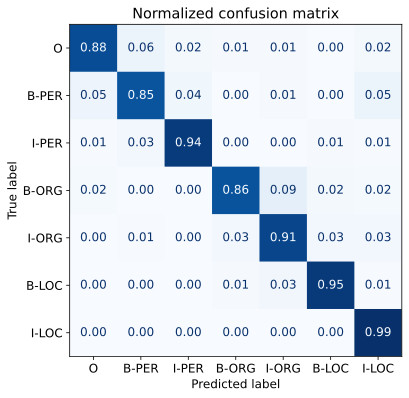

In [59]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

* From the figure above, we can see that our model tends to confuse `I-ORG` and `B-ORG` entities the most. Otherwise it is good at classifiying the remaining entities (clear by the diagonal nature of the confusion matrix)

* Now, let's examine the error on the sequence level and calculate the **total loss** by summing over the loss per token:

In [60]:
# display the token sequences with labels and the losses
def get_samples(df):
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        # Iterate over each token in the row
        for i, mask in enumerate(row["attention_mask"]):
            # Ignore tokens corresponding to padding
            if i not in {0, len(row["attention_mask"])}:
                # Append the label, predicted label, token, and loss to the corresponding lists
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        # Create a DataFrame with columns for tokens, labels, predicted labels, and losses
        # and transpose it to display as a row
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        # Yield the transposed DataFrame for display
        yield df_tmp

# Add a column to the DataFrame with the total loss for each row
df["total_loss"] = df["loss"].apply(sum)

# Sort the DataFrame by total loss and select the top 3 rows
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,5.83,0.00,0.00,0.00,10.39,9.79,8.10,5.60,5.59,0.00,5.44,6.32,0.00,7.38,7.93,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,6.87,0.00,0.00,5.99,8.06,7.49,7.06,0.00,7.42,8.64,7.29,5.87,3.20,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.39,5.46,6.03,0.00,5.97,0.00,5.86,0.00,5.61,5.89,5.79,5.81,5.50,5.32,0.00


* As we can see from the tables above, the PAN-X dataset contains wrong annotated entities since the annotations were automatically generated. Such annotations are called **silver standard** (in contrast to the **gold standard** of human-generated annotations)
* Let's look at a few examples of sequences with an openining parenthesis:

In [61]:
# select rows that have at least one token containing the unicode character "\u2581" followed by a parenthesis
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.02,0.01,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


* In general we would NOT include the parentheses and their contents as part of the named entity, but this seems to be the way the automatic extraction annotated the documents.
---
### NOTE: 
With a simple analysis, we've identified some weaknesses in both our model and the dataset. In a real case we would iterate on this step: **Cleaning up** the dataset, **Retraining** the model, **Analyzing** the new errors until we were **satisfied** with the performance.

---

* We analyzed the errors on a single language (German), but we are also intrested in the performance acrss languages. Next, we will perform some experiments to see how well the cross-lingual ransfer in XLM-R works.

## Cross-Lingual Transfer

* We have fine-tuned XLM-R on German, we can evaluate its ability to transfer to other languages via the `predict()` method of the `Trainer`:

In [62]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

* We can use this function to examine the performance on the test set and keep track of scores in a dict:

In [63]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.868


* Let's see how our fine-tuned model on German fares on Frence:

In [64]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


* Not bad, the model was able also to classify the French translation of "Kalifornien"
* Next let's quantify how well our German model fares on the **whole French** test set. First, we need to define a simple function to encode the dataset and generate the classification report on it:

In [65]:
# Encodes a dataset and generates the classification report on it
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [66]:
# hide_output
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

F1-score of [de] model on [fr] dataset: 0.701


* We see a drop of about 15 points in the F1-score. However, you have to remember that our model has NOT seen a single labeled French example!

> **Language Similarity & Performance Drop**: In general, the size of the performance drop is relate to how "far away" the languages are from each other-

* Let's evaluate the German model on the whole Italian dataset:

In [67]:
# hide_output
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [it] dataset: 0.668


* Next, we will evaluate the German model on the whole English dataset:

In [68]:
#hide_output
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [en] dataset: 0.597


* Surprisingly, our model fares **worst** on English, even though we might expect Geman to be more similar to English than Frence.
* In the next section, we will fine-tune the model **directly** on the target language.

### When Does Zero-Shot Transfer Make Sense?

* The question is, **how good** are the previous results and how do they **compare** against an XLM-R model **fine-tuned** on a monolingual corpus?
* Let's explore this question on the **French corpus** by **fine-tuning** XLM-R model on **training sets of increasing size**. By tracking the **performance** in this way, we can determine at which point **zero-shot cross-lingual transfer** is **superior**. 
* We will use same hyperparameters from the fine-tuning on the German corpus, except that we'll tweak the `logging_steps` argument of `TrainingArguments` to account for the changing training set sizes.
* We can wrap this all together in a simple function that **takes** a `DatasetDict` object corresponding to a monolingual corpus, **downsamples** it by `num_samples`, and **fine-tunes** XLM-R on that sample to **return** the metrics from the **best epoch**:

In [69]:
def train_on_subset(dataset_dict, num_samples):
    train_ds = dataset_dict["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset_dict["validation"]
    test_ds = dataset_dict["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init=model_init, 
                      args=training_args,
                      data_collator=data_collator, 
                      compute_metrics=compute_metrics,
                      train_dataset=train_ds, 
                      eval_dataset=valid_ds, 
                      tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

* In addition, we have to encode the French corpus into input IDs, attention masks, and label IDs:

In [70]:
# Encode French corpus
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

* Next, let's check that our function works by running it on a small training set:

In [71]:
# hide_output
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.758300,1.311081,0.080419
2,1.246000,1.105151,0.129342
3,1.065100,1.018110,0.183486


,num_samples,f1_score
0,250,0.16781


In [72]:
# Hack needed to exclude the progress bars in the above cell
metrics_df

,num_samples,f1_score
0,250,0.16781


* The result shows that fine-tuning on small French examples **underperforms** the **zero-shot transfer from German**. Let's increase our training set sizes to 500, 1000, 2000, and 4000 examples to get an idea of how the performance increases:

In [73]:
# hide_output
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

Epoch,Training Loss,Validation Loss,F1
1,1.530700,1.156512,0.204069
2,0.960400,0.714447,0.513481
3,0.621000,0.592238,0.602863


Epoch,Training Loss,Validation Loss,F1
1,1.183100,0.621773,0.587196
2,0.478500,0.407466,0.723810
3,0.302800,0.383328,0.751958


Epoch,Training Loss,Validation Loss,F1
1,0.800700,0.426903,0.711352
2,0.334300,0.351752,0.783895
3,0.219100,0.338938,0.809484


Epoch,Training Loss,Validation Loss,F1
1,0.615300,0.342968,0.780003
2,0.278600,0.295577,0.802980
3,0.185100,0.284087,0.833978


* We can compare how **fine-tuning of French samples** compares to zero-shot cross-lingual transfer from German by plotting the F1-scores on the test set as a function of increasing training set size:

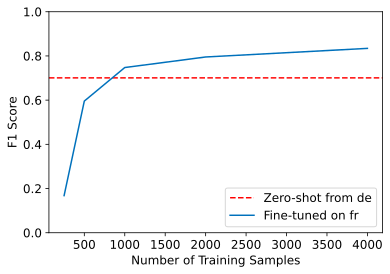

In [74]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

* As we can see from the plot above, zero-shot transfer remains cometitive until about 750 training examples, after which fine-tuning on French reaches a similar level of performance to what we obtained when fine-tuning on German.

### Fine-Tuning on Multiple Languages at Once

* Let's fine-tune our XLM-R model on multiple languages at the same time to see what type of gains we can get.
* First, use `concatenate_datasets()` function from 🤗 Datasets inside a function to concatenate the German and French corpora together:

In [77]:
from datasets import concatenate_datasets, DatasetDict

def concatenate_splits(corpora):
    # Initialize an empty DatasetDict to hold the concatenated datasets
    multi_corpus = DatasetDict()

    # Loop through each split in the first corpus. i.e., train, test, validation
    for split in corpora[0].keys():
        # Concatenate the split from each corpus
        concat_split = concatenate_datasets([corpus[split] for corpus in corpora])
        # Shuffle the concatenated split and add it to the multi_corpus dictionary
        multi_corpus[split] = concat_split.shuffle(seed=42)

    # Return the concatenated dataset
    return multi_corpus


In [78]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

* For training, we will use the same hyperparameters from the previous sections, so we can simply update the logging steps, model, and datasets in the trainer:

In [79]:
# hide_output
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = False ##True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, 
                  args=training_args,
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, 
                  train_dataset=panx_de_fr_encoded["train"],
                  eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
#trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.284500,0.183133,0.824932
2,0.144900,0.164266,0.847887
3,0.092900,0.165449,0.859001


TrainOutput(global_step=2145, training_loss=0.17408516268074373, metrics={'train_runtime': 400.6496, 'train_samples_per_second': 128.491, 'train_steps_per_second': 5.354, 'total_flos': 1140291491923584.0, 'train_loss': 0.17408516268074373, 'epoch': 3.0})

* Let's have a look at how the model **performs** on the test set of **each** language:

In [80]:
#hide_output
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [de] dataset: 0.867


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [fr] dataset: 0.855


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [it] dataset: 0.808


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [en] dataset: 0.680


* Our model performs much better on the French split than before.
* Intersetingly, its performance on the Italian and English splits also improves by roughly 10 points!
* Let's compare the performance of **fine-tuning on each language** separately against multilingual learning **on all the corpora**.
> Since we have already fine-tuned on the German corpus, we can fine-tune on the remaining languages with our `train_on_subset()` function, with `num_samples` equal to the number of examples in the training set:

````python
# performance of the XLM-R model fine-tuned on German dataset
f1_scores
> defaultdict(dict,
            {'de': {'de': 0.8683108948976129,
                    'fr': 0.7007746933505488,
                    'it': 0.6678067550235143,
                    'en': 0.5967101531480431}})
````

In [84]:
# Create a list of multilingual corpora 
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]: # 'fr', 'it', 'en'
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of the mulitlingual corpora 
    corpora.append(ds_encoded)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,F1
1,0.598900,0.241769,0.836272
2,0.261700,0.146621,0.898434
3,0.167200,0.100825,0.923850


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,F1
1,0.818700,0.332518,0.733656
2,0.282900,0.255394,0.800321
3,0.189400,0.240052,0.824583


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,F1
1,1.150400,0.599185,0.478632
2,0.514700,0.430684,0.646832
3,0.371700,0.393189,0.703247


````python 
# Performanc of XLM-R model fine-tuned on each language separately
defaultdict(dict,
            {'de': {'de': 0.8683108948976129,  # f1 of XLM-R fine-tuned on German and tested on German 
                    'fr': 0.7007746933505488,
                    'it': 0.6678067550235143,
                    'en': 0.5967101531480431},
             'fr': {'fr': 0.8330673475901692}, # f1 of XLM-R fine-tuned on French and tested on French 
             'it': {'it': 0.8159931212381772},
             'en': {'en': 0.674364896073903}})
````

* now that we have fine-tuned on each language's corpus, the next step is to concatenate all the splits together to create a multilingual corpus of all languages using `concatenate_splits()` function:

In [86]:
# create multilingual corpus
corpora_encoded = concatenate_splits(corpora)

In [87]:
# Train the model on the multilingual corpus
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, 
                  args=training_args,
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, 
                  train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])

trainer.train()
#trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.284500,0.165179,0.837984
2,0.144900,0.133687,0.866835
3,0.092900,0.126987,0.881655


TrainOutput(global_step=2145, training_loss=0.17408516268074373, metrics={'train_runtime': 405.3999, 'train_samples_per_second': 126.986, 'train_steps_per_second': 5.291, 'total_flos': 1140291491923584.0, 'train_loss': 0.17408516268074373, 'epoch': 3.0})

* Evaluate the XLM-R model fine-tuned on a mulitlingual corpus on each test set:

In [88]:
# hide_output
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [89]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8683,0.7008,0.6678,0.5967
each,0.8683,0.8331,0.8160,0.6744
all,0.8672,0.8552,0.8083,0.6800


* Multilingual learning can provide **significant gain** in performance, especially if the **low-resource languages** for cross-lingual transfer belong to **similar language families**.

## Interacting with Model Widgets